<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/Sarcasm_detection_XLNet_semeval_run1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Oct  2 11:42:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -qq transformers

     |████████████████████████████████| 2.9 MB 2.7 MB/s 
     |████████████████████████████████| 636 kB 56.7 MB/s 
     |████████████████████████████████| 895 kB 71.1 MB/s 
     |████████████████████████████████| 56 kB 6.3 MB/s 
     |████████████████████████████████| 3.3 MB 77.7 MB/s 


### Making the necessary imports

In [14]:
!pip install emoji

     |████████████████████████████████| 168 kB 2.7 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=4dbd0de9ed1c792832957253da9cee9aa7870fd267182b8ce38a9d1ebb097c55
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


In [1]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim



In [2]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data Preprocessing

In [4]:
df = pd.read_csv('./drive/MyDrive/datasets/cleaned_semeval_wnotebook_5.csv')
df.head()

,Tweet index,Label,Tweet
0,1,1,sweet united nations video just in time for ch...
1,2,1,we are rumored to have talked to erv is agent ...
2,3,1,hey there nice to see you minnesotand winter w...
3,4,0,3 episodes left i am dying over here
4,5,1,i cannot breathe was chosen as the most notabl...


In [5]:
df = df.drop(['Tweet index'],axis=1)

In [6]:
df.dropna(subset = ["Tweet"], inplace=True)

In [7]:
!pip install demoji

In [8]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [9]:
df['emoji_list'] = df['Tweet'].apply(demoji_text)

In [10]:
f= list(filter(None, df['emoji_list']))

In [11]:
print(f)

[{'😡': 'pouting face'}, {'😬': 'grimacing face'}, {'❤️': 'red heart'}, {'😅': 'grinning face with sweat'}, {'😁': 'beaming face with smiling eyes'}, {'😐': 'neutral face'}, {'😱': 'face screaming in fear'}, {'👭': 'women holding hands', '☺': 'smiling face'}, {'💯': 'hundred points', '😳': 'flushed face'}, {'😴': 'sleeping face'}, {'💩': 'pile of poo'}, {'😩': 'weary face'}, {'😑': 'expressionless face'}, {'🎶': 'musical notes'}, {'😃': 'grinning face with big eyes', '😇': 'smiling face with halo'}, {'😂': 'face with tears of joy'}, {'🙌': 'raising hands'}, {'😲': 'astonished face', '😂': 'face with tears of joy'}, {'✈️': 'airplane', '❤️': 'red heart', '🌏': 'globe showing Asia-Australia'}, {'😘': 'face blowing a kiss', '😍': 'smiling face with heart-eyes'}, {'😳': 'flushed face', '😘': 'face blowing a kiss', '😍': 'smiling face with heart-eyes'}, {'🎶': 'musical notes', '☀️': 'sun'}, {'🙊': 'speak-no-evil monkey'}, {'😭': 'loudly crying face'}, {'😩': 'weary face'}, {'☀': 'sun', '🌴': 'palm tree'}, {'🔫': 'water pis

In [12]:
any(f)

True

In [13]:
all_keys = set().union(*(d.keys() for d in f))

In [14]:
print(all_keys)

{'✌️', '👸', '🚶', '🍕', '👭', '🔫', '🐁', '💩', '⭕', '👉', '😱', '😕', '🐱', '☺️', '☺', '😇', '🔥', '🍴', '😉', '💃', '😭', '☹', '🎤', '📷', '🍆', '🍷', '😀', '🎅', '😆', '✋', '🏆', '⚾', '💻', '🙏', '🚀', '💨', '💕', '👳', '😰', '🎉', '☀', '☀️', '💣', '😲', '📖', '💖', '😎', '😻', '❄', '🎻', '😢', '💚', '🐣', '🍵', '🐶', '💘', '🎼', '😫', '😊', '👍', '🇬🇧', '➡️', '👏', '😁', '☁', '❤️', '🇫🇴', '👤', '😘', '🔌', '🙌', '🙊', '💤', '❤', '🙆', '💔', '🏃', '🍻', '😒', '💗', '🎶', '😤', '🙈', '💭', '🎵', '😛', '🌴', '😡', '👑', '😟', '😅', '😄', '😠', '💰', '🍟', '⛄', '😣', '💀', '😵', '🚑', '♥', '✈️', '😏', '😬', '😶', '👎', '👌', '😞', '⚡', '❌', '✨', '☔', '😋', '💜', '😝', '🙀', '🍸', '🔜', '😳', '👊', '💾', '💪', '🐸', '🚓', '😔', '👯', '🚒', '💅', '🙋', '☕', '😖', '💯', '🛀', '😐', '🔪', '❄️', '✅', '😜', '💋', '👐', '👈', '🙅', '😪', '😩', '💦', '😃', '🏀', '💓', '🎧', '😂', '💧', '😷', '🙇', '😍', '😑', '💁', '🍹', '😴', '🚍', '🎄', '🌏', '📚', '🎁', '🆘'}


In [ ]:
!pip install emoji

     |████████████████████████████████| 185 kB 8.4 MB/s 
  Created wheel for emoji: filename=emoji-1.5.0-py3-none-any.whl size=187457 sha256=7ae52e55a7c35c7219fd2347c0d969e8fe057d11db38012f73daa8ee88dded67
  Stored in directory: /root/.cache/pip/wheels/db/b5/f6/b39abf14e94b3d6640613bbe630a66c10ccf7a12882d064fb5
Successfully built emoji


In [15]:
import emoji
def extract_emojis(s):
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)

In [16]:
text= 'sexy ladywaynesworld excellent  😁☺😊'

In [17]:
extract_emojis(text)

'sexy ladywaynesworld excellent   😁  ☺  😊 '

In [18]:
df['Tweet'] = df['Tweet'].apply(extract_emojis)

In [19]:
df.columns = df.columns.str.lstrip()

In [20]:
df.head()

,Label,Tweet,emoji_list
0,1,sweet united nations video just in time for ch...,{}
1,1,we are rumored to have talked to erv is agent ...,{}
2,1,hey there nice to see you minnesotand winter w...,{}
3,0,3 episodes left i am dying over here,{}
4,1,i cannot breathe was chosen as the most notabl...,{}


In [ ]:
pd.options.display.max_colwidth = 130

In [ ]:
df.iloc[1959:1967]

,Label,Tweet
1959,1,so glad they have found a way to make the gospel socially relevant to klingons
1960,0,oo ummmso like rt from our family to yours have a safe and happythanksgiving
1961,0,my death will likely be caused by at the wrong time
1962,0,everybody just keeps saying gronk and large contingent of patriots who else is there with rob
1963,1,dad and step mom bitching at each other now it is christmas 😊 🎄 😤 disgusted
1964,1,internet got me like 😩 stillalive
1965,1,the joy i have for overnight stakeouts
1967,1,gutted doyle has gone back to wwfc i do not think we saw what he is capable of cpfc


In [ ]:
import re
emoji_1 = re.compile('[\\u203C-\\u3299\\U0001F000-\\U0001F644]')

In [ ]:
emoji_list= list(filter(emoji_1.match, df['Tweet']))

In [ ]:
emo_found= ' '.join(emoji for emoji in emoji_list)

In [ ]:
!pip install emoji

     |████████████████████████████████| 184 kB 6.8 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=fcf234031ca52194e9d5d26ea579279a74e282e770a71292f4ca30160456569b
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji


In [ ]:
from emoji import UNICODE_EMOJI

def get_emoji_set(text):
    return {letter for letter in text if letter in UNICODE_EMOJI['en'] }

In [ ]:
c = get_emoji_set(emo_found)

In [ ]:
print(c)

{'😢', '🏥', '😍', '😔', '😘', '🎧', '😳', '❄', '💣', '☕', '🍃', '👌', '😛', '🐾', '💎', '😩', '⛄', '🌏', '👼', '😊', '🎄', '💯', '🍩', '💚', '🙊', '😕', '🍻', '📱', '🙈', '🙉', '🎈', '🎶', '😇', '💕', '😒', '💝', '🎎', '🐸', '☹', '⭐', '💊', '✨', '😙', '👫', '🌞', '😱', '🍀', '💦', '🍊', '🐒', '☺', '💗', '🎅', '🎀', '🐉', '😏', '🏈', '😆', '😋', '❤', '🐶', '🎁', '🌍', '♥', '😂', '😝', '👑', '▶'}


In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,Label,Tweet
2522,0,dusty as usual 🔌 redbucket
1674,1,and all i want to do is blast music and get ready for my trip but my second roommate is sleeping and i suffer from being consi...
1951,0,trivia crack is taking over my life
676,1,who france impede free market capitalism socialists no not france shocker the best rocks suck it france
525,1,it will be ok just get your ta to fix it
1489,0,all the more reason for it competition breeds innovation and the consumer wins
1397,1,thank you strange vet husband at the bar for reminding me that i will be in debt until i die studentloans
1624,1,gotta love the friends i have out here hahahah nosuchthing
2963,1,who would have imagined that jakeplummer smokes weed regularly outsidethelines
189,1,my secret name is lizard squad i like to ruin people is fun time follow and rt to a billion and you will have fun psn giveitup


In [ ]:
import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    text = re.sub(r'[^\w\s]',' ', text)
    return text

In [ ]:
df['Tweet'] = df['Tweet'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


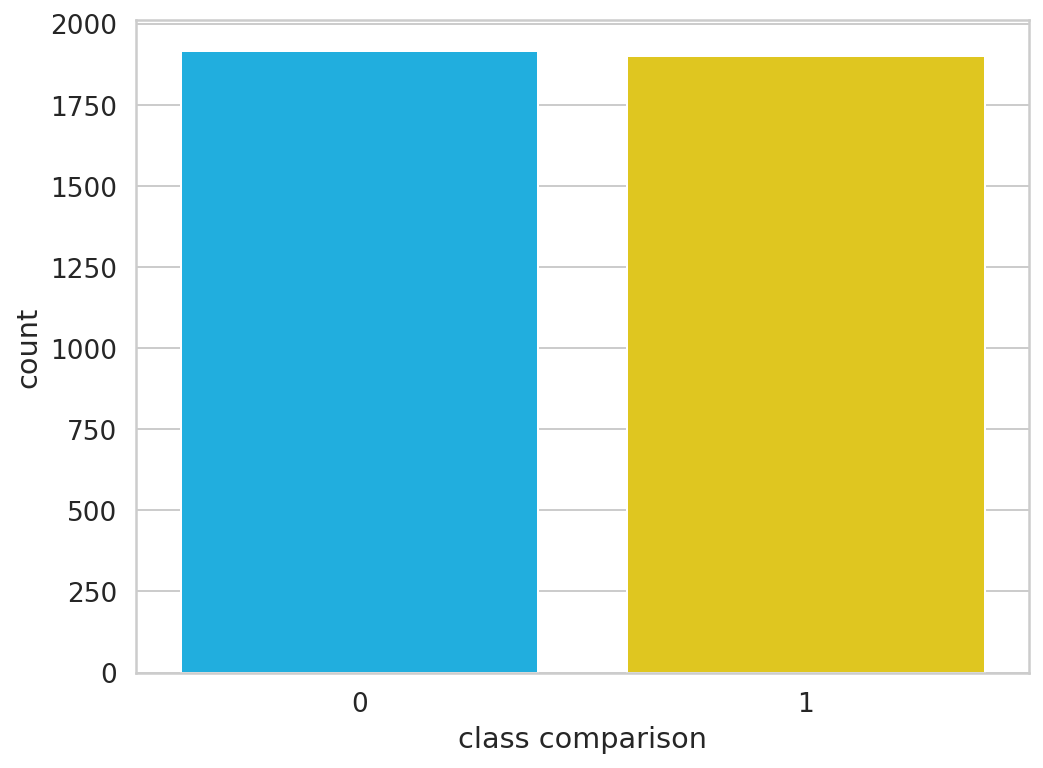

In [21]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.Label)
plt.xlabel('class comparison');

In [22]:
df['Label'].value_counts()

0    1915
1    1901
Name: Label, dtype: int64

In [23]:
class_names = ['1', '0']

In [24]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.3 MB/s 


### Playing with XLNetTokenizer

In [24]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer.add_tokens(['🎼', '😇', '👳', '😐', '😊', '👤', '👏', '😭', '😉', '🍆', '🍷', '✨', '🍴', '🔥', '🏀', '😻', '💯', '🆘', '♥', '😱', '🙈', '⚾', '🎵', '🐸', '🎄', '🙆', '💰', '🍵', '😪', '💗', '🚍', '🎁', '❄️', '😏', '🍸', '😀', '🌏', '👯', '💘', '🐱', '😒', '🇬🇧', '📷', '💃', '☔', '☺️', '💋', '🚶', '💧', '🔜', '🙀', '💅', '🎤', '🎻', '🚑', '😫', '☁', '🍹', '👊', '✈️', '💔', '😄', '💁', '🐁', '🎉', '🚒', '😁', '❌', '😡', '😰', '🍕', '😠', '😕', '😵', '💻', '🙋', '☀️', '🐶', '😜', '👌', '🏃', '💪', '❄', '👎', '👭', '❤', '🎧', '😳', '😝', '⚡', '😲', '😤', '😛', '💭', '😖', '🚓', '💩', '👍', '💖', '🎶', '💜', '✅', '🙏', '🛀', '👑', '⭕', '😶', '☀', '😬', '🔪', '✋', '😔', '💦', '😷', '💤', '☹', '👉', '🐣', '➡️', '💕', '😋', '👐', '💓', '🔫', '🙊', '⛄', '😎', '😆', '💣', '☕', '😩', '😟', '💾', '🙅', '😴', '💚', '🍻', '😢', '👈', '🙌', '😞', '😑', '🌴', '🇫🇴', '😅', '❤️', '😘', '🔌', '🚀', '🏆', '😍', '👸', '💀', '💨', '📚', '😃', '🙇', '🍟', '📖', '✌️', '🎅', '😣', '☺', '😂']
)
print(tokenizer)

PreTrainedTokenizer(name_or_path='xlnet-base-cased', vocab_size=32000, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='left', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '<sep>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<eop>', '<eod>']})


In [25]:
input_txt = "love it when your typing at work and a spider comes out from the keyboard and hangs out between your fingers 🙈"


In [26]:
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=32, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, padding=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2228: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


In [27]:
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [28]:
print('input_ids : ',encodings['input_ids'])

input_ids :  tensor([[  564,    36,    90,    73, 20288,    38,   154,    21,    24, 13515,
           909,    78,    40,    18,  8097,    21,  5322,    23,    78,   161,
            73,  3267, 32020,     4,     3]])


In [29]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['▁love',
 '▁it',
 '▁when',
 '▁your',
 '▁typing',
 '▁at',
 '▁work',
 '▁and',
 '▁a',
 '▁spider',
 '▁comes',
 '▁out',
 '▁from',
 '▁the',
 '▁keyboard',
 '▁and',
 '▁hang',
 's',
 '▁out',
 '▁between',
 '▁your',
 '▁fingers',
 '🙈',
 '<sep>',
 '<cls>']

In [30]:
type(encodings['attention_mask'])

torch.Tensor

In [31]:
tokens = tokenizer.tokenize(input_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {input_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: love it when your typing at work and a spider comes out from the keyboard and hangs out between your fingers 🙈
   Tokens: ['▁love', '▁it', '▁when', '▁your', '▁typing', '▁at', '▁work', '▁and', '▁a', '▁spider', '▁comes', '▁out', '▁from', '▁the', '▁keyboard', '▁and', '▁hang', 's', '▁out', '▁between', '▁your', '▁fingers', '🙈']
Token IDs: [564, 36, 90, 73, 20288, 38, 154, 21, 24, 13515, 909, 78, 40, 18, 8097, 21, 5322, 23, 78, 161, 73, 3267, 32020]


In [32]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=128, dtype=torch.Tensor ,truncating="post",padding="post")

In [33]:
attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask) 
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
encodings['input_ids']

tensor([[  564,    36,    90,    73, 20288,    38,   154,    21,    24, 13515,
           909,    78,    40,    18,  8097,    21,  5322,    23,    78,   161,
            73,  3267, 32020,     4,     3]])

### Checking the distribution of token lengths

In [35]:
token_lens = []

for txt in df['Tweet']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


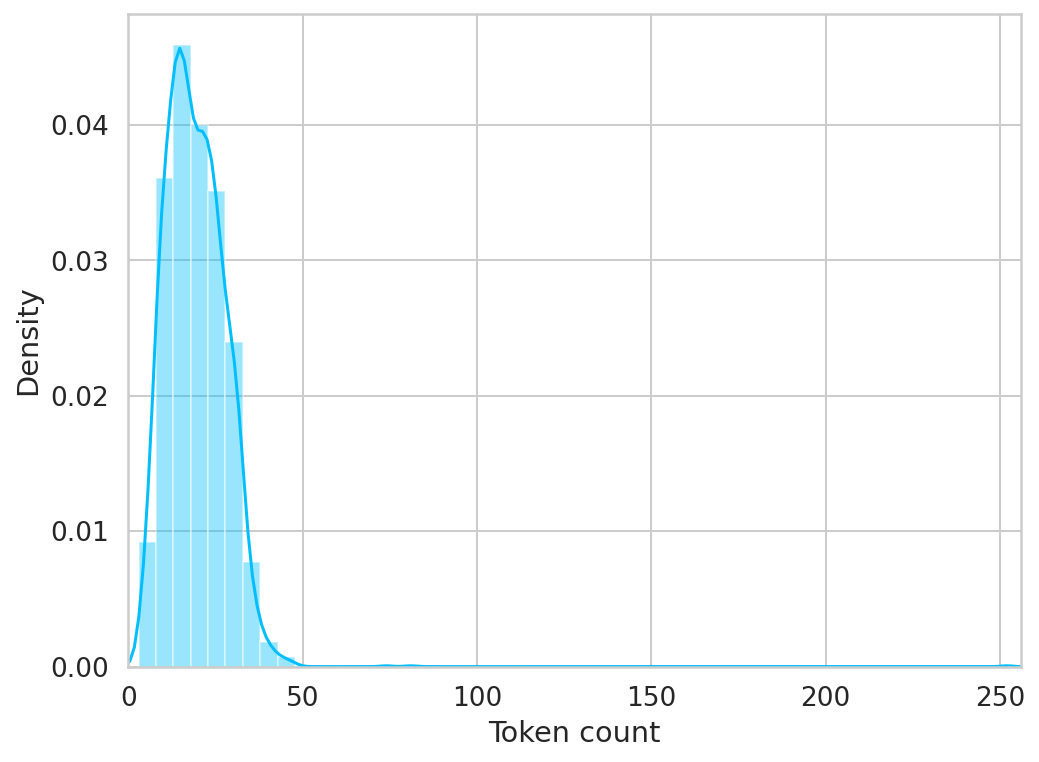

In [36]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [37]:
MAX_LEN = 128

### Custom Dataset class

In [38]:
class sarcasmDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        Tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        Tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'tweets': Tweet,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [39]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=101)

In [40]:
df_train.shape, df_val.shape, df_test.shape

((3052, 3), (534, 3), (230, 3))

### Custom Dataloader

In [41]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = sarcasmDataset(
    tweets=df.Tweet.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [42]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

### Loading the Pre-trained XLNet model for sequence classification from huggingface transformers

In [43]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model.resize_token_embeddings(len(tokenizer))
print(len(tokenizer))
model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

32164


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32164, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32164, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

### Setting Hyperparameters

In [ ]:
a= 0.0005
b=0.001

r = a + (b-a).*rand(10,1);

print(r)

SyntaxError: ignored

In [ ]:
import random

r= 0.001+(random()*(0.0005-0.001))

print(r)

TypeError: ignored

In [ ]:
line = input("Type a float: ")
if (float(line) > 0.001):
    print ("input is bigger")
else:
    print ("input is lower")

Type a float: 0.0007
input is lower


In [44]:
EPOCHS = 5

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=4e-5, eps= 1e-8)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

### Sanity check with one batch

In [45]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['tweets', 'input_ids', 'attention_mask', 'targets'])

In [46]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(64,-1).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([64, 128])
torch.Size([64, 128])


In [47]:
input_ids[0]

tensor([[  137,    17,   150,  1755, 11989,    34,    24,  1466,    17, 11709,
           101,   223,     4,     3,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

### Defining the training step function

In [48]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].reshape(-1,128).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

### Defining the evaluation function

In [49]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(-1,128).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

### Fine-tuning the pre-trained model

In [51]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), './xlnet_semeval_run13.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.6636723279953003 Train accuracy 0.5932469223484849
Val loss 0.6372392111354404 Val accuracy 0.6387310606060606

Epoch 2/5
----------
Train loss 0.5716758066167434 Train accuracy 0.6971472537878788
Val loss 0.6857972277535332 Val accuracy 0.6298926767676768

Epoch 3/5
----------
Train loss 0.452635383233428 Train accuracy 0.7758641098484849
Val loss 0.718199716673957 Val accuracy 0.6595643939393939

Epoch 4/5
----------
Train loss 0.3611489941055576 Train accuracy 0.8407611268939394
Val loss 0.8513825602001615 Val accuracy 0.6369949494949494

Epoch 5/5
----------
Train loss 0.3018253380432725 Train accuracy 0.8692589962121212
Val loss 0.8396104309293959 Val accuracy 0.6387310606060606

CPU times: user 4min 8s, sys: 4.44 s, total: 4min 12s
Wall time: 4min 6s


In [52]:
exit()

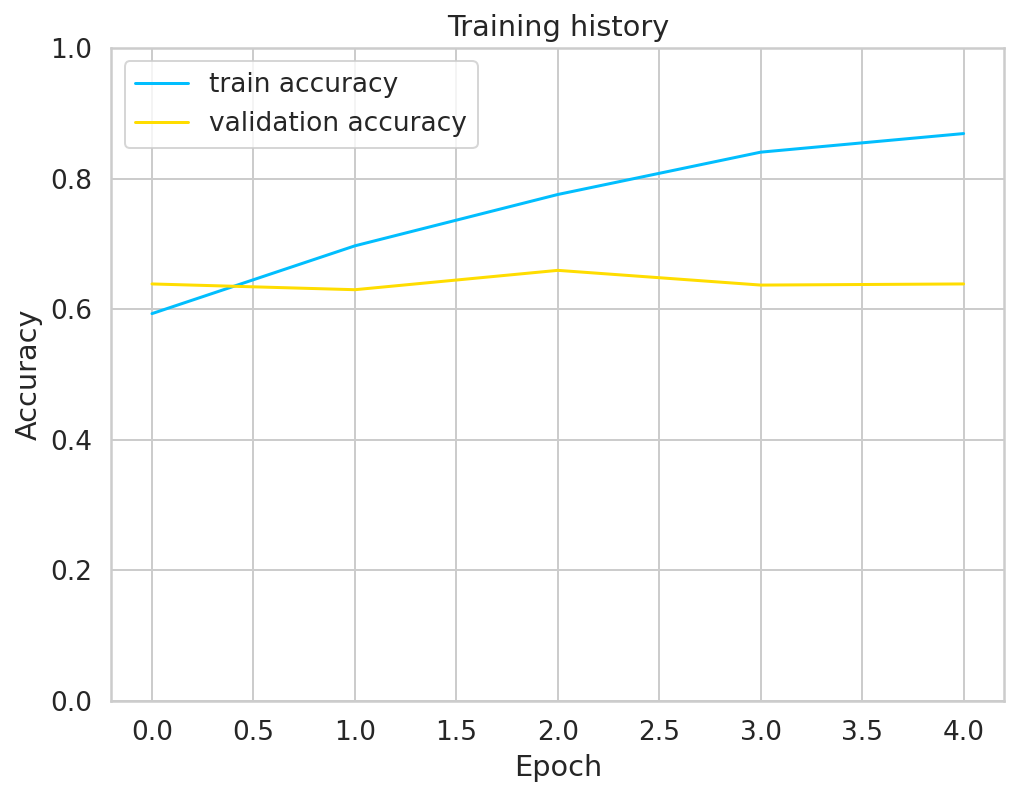

In [52]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

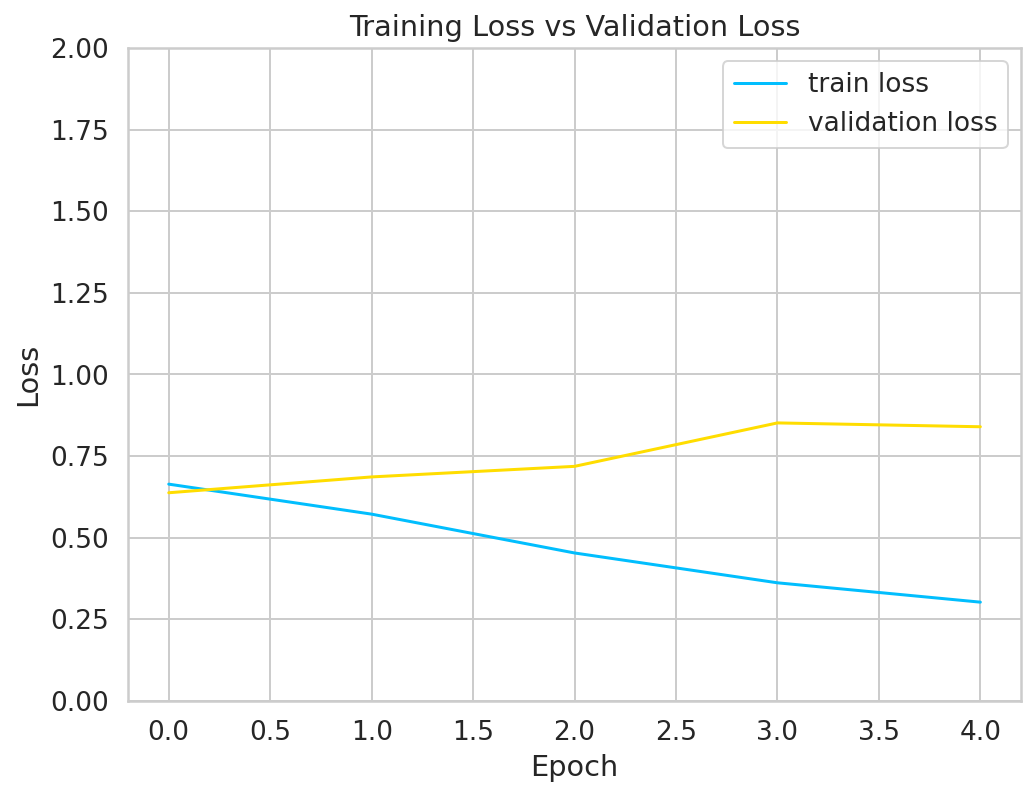

In [53]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2]);

### Evaluation of the fine-tuned model

In [54]:
model.load_state_dict(torch.load('./xlnet_semeval_run13.bin',map_location=torch.device('cpu')))

<All keys matched successfully>

In [55]:
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32164, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [56]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.6593338815789473
Test Loss : 0.7169802635908127


In [57]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["tweets"]
            input_ids = d["input_ids"].reshape(-1,128).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return tweet_texts, predictions, prediction_probs, real_values

In [58]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [59]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.71      0.57      0.63       118
           0       0.62      0.75      0.68       112

    accuracy                           0.66       230
   macro avg       0.66      0.66      0.65       230
weighted avg       0.66      0.66      0.65       230



### Custom prediction function on raw text

In [60]:
def predict_sentiment(text):
    tweets = text

    encoded_review = tokenizer.encode_plus(
    tweets,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(-1,128).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Non Sarcasm Score ", probs[1])
    print("Sarcasm score:", probs[0])
    print(f'tweet text: {tweets}')
    print(f'Sentiment  : {class_names[prediction]}')

In [61]:
text = "Nice perfume. How long did you marinate in it?"
predict_sentiment(text)

Non Sarcasm Score  0.07674930989742279
Sarcasm score: 0.9232507348060608
tweet text: Nice perfume. How long did you marinate in it?
Sentiment  : 1


In [63]:
text = "london and traffic jam is synonyms"
predict_sentiment(text)

Non Sarcasm Score  0.7166659832000732
Sarcasm score: 0.28333401679992676
tweet text: london and traffic jam is synonyms
Sentiment  : 0
